In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import pickle

In [2]:
DATASET_PATH = 'dataset'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

full_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = full_dataset.class_names
num_classes = len(class_names)

dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

train_ds = full_dataset.take(train_size)
val_ds = full_dataset.skip(train_size).take(val_size)
test_ds = full_dataset.skip(train_size + val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 10397 files belonging to 12 classes.


In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
], name="data_augmentation")

base_model = ResNet50(input_shape=IMAGE_SIZE + (3,),
                      include_top=False,
                      weights='imagenet')
base_model.trainable = False

inputs = Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x) 
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs, outputs)

In [4]:
model_resnet.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

model_resnet.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
MODEL_PATH_RESNET = 'models/resnet50_classifier.h5'

model_checkpoint = ModelCheckpoint(MODEL_PATH_RESNET, monitor='val_loss', save_best_only=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [5]:
EPOCHS = 100

history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
260/260 [==============================] - 537s 2s/step - loss: 1.7372 - accuracy: 0.4468 - val_loss: 0.8792 - val_accuracy: 0.7490
Epoch 2/100
260/260 [==============================] - 475s 2s/step - loss: 0.7826 - accuracy: 0.7651 - val_loss: 0.5511 - val_accuracy: 0.8486
Epoch 3/100
260/260 [==============================] - 472s 2s/step - loss: 0.5633 - accuracy: 0.8309 - val_loss: 0.4340 - val_accuracy: 0.8760
Epoch 4/100
260/260 [==============================] - 483s 2s/step - loss: 0.4722 - accuracy: 0.8559 - val_loss: 0.3685 - val_accuracy: 0.8916
Epoch 5/100
260/260 [==============================] - 484s 2s/step - loss: 0.4140 - accuracy: 0.8690 - val_loss: 0.3296 - val_accuracy: 0.9062
Epoch 6/100
260/260 [==============================] - 520s 2s/step - loss: 0.3654 - accuracy: 0.8843 - val_loss: 0.3011 - val_accuracy: 0.9121
Epoch 7/100
260/260 [==============================] - 499s 2s/step - loss: 0.3314 - accuracy: 0.8980 - val_loss: 0.2783 - val_accuracy:


--- Mengevaluasi pada Test Set ---
33/33 [==============================] - 41s 1s/step - loss: 0.1895 - accuracy: 0.9411
Test Loss: 0.1895
Test Accuracy: 94.11%


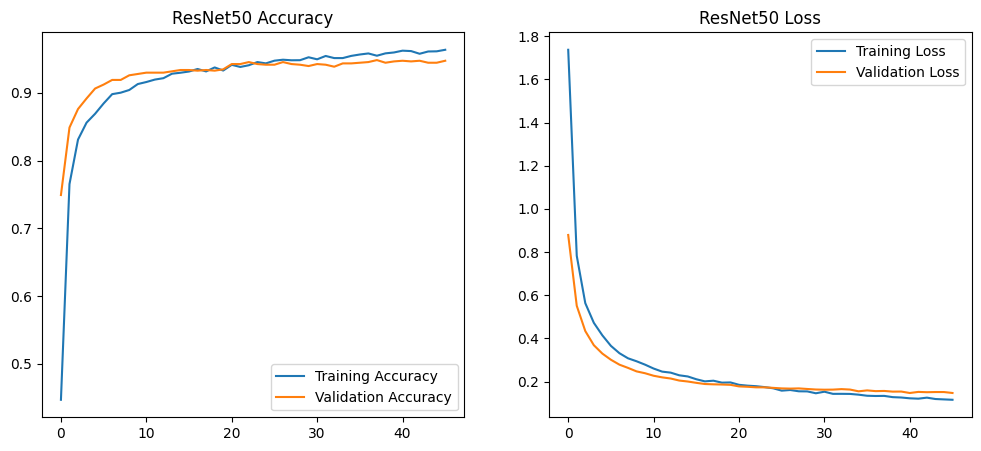

In [7]:
# Evaluasi akhir pada data_test (10% khusus)
print("\n--- Mengevaluasi pada Test Set ---")
results = model_resnet.evaluate(test_ds)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")

# Plot Akurasi & Loss
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ResNet50 Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('ResNet50 Loss')
plt.show()

33/33 [==============================] - 44s 1s/step


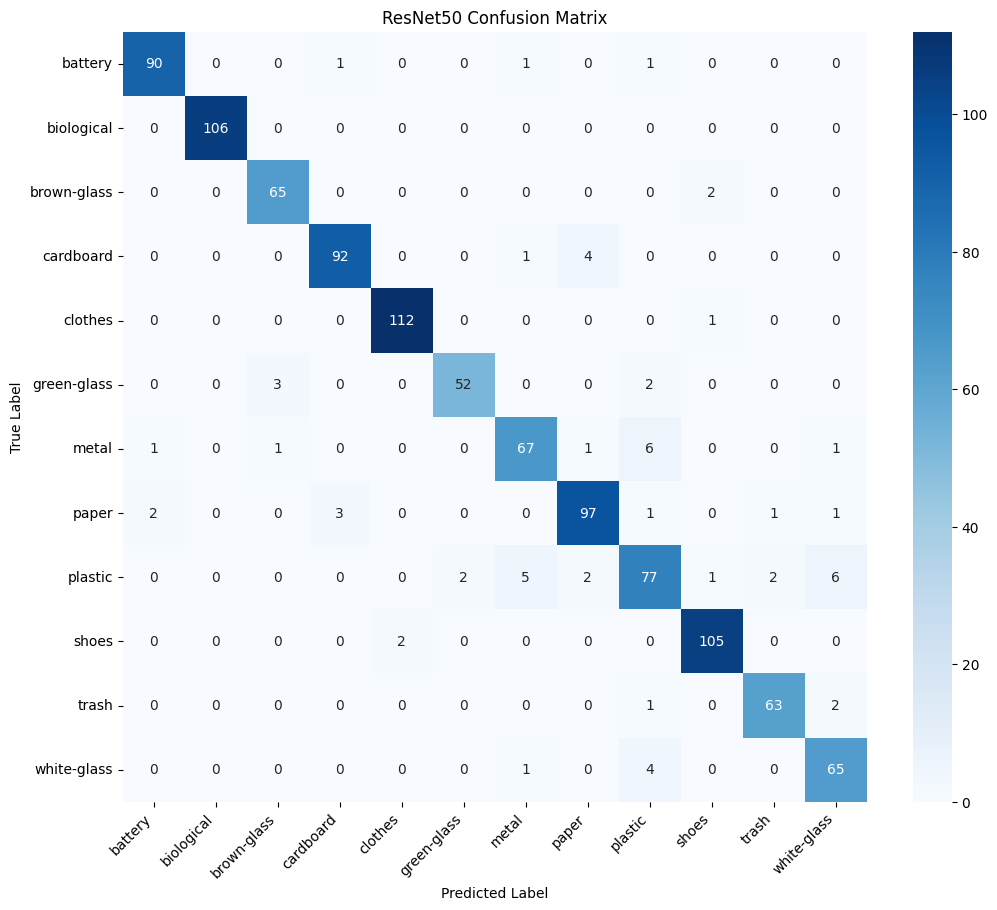

In [8]:
y_pred_probs = model_resnet.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet50 Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

In [9]:
CLASS_NAMES_PATH = 'models/class_names.pkl'
if not os.path.exists('models'):
    os.makedirs('models')
    
with open(CLASS_NAMES_PATH, 'wb') as f:
    pickle.dump(class_names, f)
print(CLASS_NAMES_PATH)

models/class_names.pkl
